In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

In [2]:
target = "subscribed"
df = pd.read_csv(os.path.join("..", "data", "preprocessed", "bank-additional-full-preprocessed-clean.csv"))
features = list(set(df.columns) - {target})
df.head()

,age,default,housing,loan,contact,n_contacts_current,pdays,n_contacts_previous,emp.var.rate,cons.price.idx,...,job_student,job_technician,job_unemployed,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree
0,0.093484,1.949941,0.928997,-0.429012,-1.322973,-0.56693,0.195587,-0.349462,0.648784,0.726051,...,-0.147159,-0.442995,-0.158579,2.983737,-0.242475,-0.414526,-0.548422,-0.021166,-0.381893,-0.648165
1,0.861065,1.949941,0.928997,-0.429012,-1.322973,-0.56693,0.195587,-0.349462,0.648784,0.726051,...,-0.147159,-0.442995,-0.158579,-0.335150,-0.242475,-0.414526,-0.548422,-0.021166,-0.381893,1.542818
2,0.861065,-0.512836,-1.076429,-0.429012,-1.322973,-0.56693,0.195587,-0.349462,0.648784,0.726051,...,-0.147159,2.257364,-0.158579,-0.335150,-0.242475,2.412394,-0.548422,-0.021166,-0.381893,-0.648165
3,0.093484,1.949941,0.928997,-0.429012,-1.322973,-0.56693,0.195587,-0.349462,0.648784,0.726051,...,-0.147159,2.257364,-0.158579,-0.335150,-0.242475,-0.414526,-0.548422,-0.021166,2.618535,-0.648165
4,0.477275,1.949941,0.928997,-0.429012,-1.322973,-0.56693,0.195587,-0.349462,0.648784,0.726051,...,-0.147159,-0.442995,-0.158579,-0.335150,-0.242475,2.412394,-0.548422,-0.021166,-0.381893,-0.648165


In [3]:
X = df[features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify = y)

negative_weight = y.sum()/y.shape[0]
positive_weight = (y.shape[0] - y.sum())/y.shape[0]
class_weight = {0: negative_weight, 1: positive_weight}
train_sample_weights = y_train.map(class_weight)
test_sample_weights = y_test.map(class_weight)

skf = StratifiedKFold(n_splits = 5)

def weighted_acc(y_true, y_pred):
    sample_weights = y_true.map({0: negative_weight, 1: positive_weight})
    return accuracy_score(y_true, y_pred, sample_weight = sample_weights)

cv_scoring = {
    "accuracy": make_scorer(weighted_acc),
    "precision": "precision", 
    "recall": "recall",
    "roc_auc": make_scorer(roc_auc_score)
}

def downsample(X, y):
    positive_indexes = y[y == 1].index
    negative_sample_indexes = y[y == 0].sample(len(positive_indexes), random_state = 42).index

    y_downsampled = y.loc[list(positive_indexes) + list(negative_sample_indexes)].sample(frac = 1., random_state = 42)
    X_downsampled = X.loc[y_downsampled.index]
    return X_downsampled, y_downsampled

def train_cv_model(model, X = X_train, y = y_train, transformations = [], fit_params = None, model_name = None):
    X_copy, y_copy = X.copy(), y.copy()
    for transformation in transformations:
        X_copy, y_copy = transformation(X_copy, y_copy)

    cv_results = cross_validate(model, X_copy, y_copy, cv = skf, n_jobs = 3, scoring = cv_scoring, fit_params = fit_params)
    wacc_mean = cv_results["test_accuracy"].mean()
    wacc_std = cv_results["test_accuracy"].std()
    auc_mean = cv_results["test_roc_auc"].mean()
    auc_std = cv_results["test_roc_auc"].std()
    print(f"Finished training model {model.__class__.__name__}, weighted_acc: {wacc_mean:.3f} ± {2*wacc_std:.3f}, roc_auc: {auc_mean:.3f} ± {2*auc_std:.3f}")
    return pd.Series({
        "wacc_mean": wacc_mean, 
        "wacc_std": wacc_std,
        "precision_mean": cv_results["test_precision"].mean(),
        "precision_std": cv_results["test_precision"].std(),
        "recall_mean": cv_results["test_recall"].mean(),
        "recall_std": cv_results["test_recall"].std(),
        "roc_auc_mean": cv_results["test_roc_auc"].mean(),
        "roc_auc_std": cv_results["test_roc_auc"].std()
    }, name = model_name if model_name else model.__class__.__name__)


def evaluate_model(model, transformations = [], fit_params = None, model_name = None):
    X_copy, y_copy = X_train.copy(), y_train.copy()
    for transformation in transformations:
        X_copy, y_copy = transformation(X_copy, y_copy)

    model.fit(X_copy, y_copy, **fit_params)
    y_test_pred = model.predict(X_test)
    weighted_accuray = accuracy_score(y_test, y_test_pred, sample_weight = test_sample_weights)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)

    plot_results(model, model_name)

    return pd.Series({
        "wacc": weighted_accuray, 
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
    }, name = model_name if model_name else model.__class__.__name__)

def plot_results(model, model_name = None):
    fig, ax = plt.subplots(ncols = 2, figsize = (15, 4))

    fig.suptitle(f"Results for {model_name if model_name else model.__class__.__name__} at test set")

    plot_confusion_matrix(model, X_test, y_test, ax = ax[0], normalize = "true", cmap = "Blues")
    ax[0].set_title("Confusion Matrix")

    plot_roc_curve(model, X_test, y_test, ax = ax[1])
    ax[1].set_title("ROC Curve")
    ax[1].grid(0.5)

    if not os.path.exists(os.path.join("..", "results", "figures")): os.mkdir(os.path.join("..", "results", "figures"))
    fig.savefig(os.path.join("..", "results", "figures", f"{model_name if model_name else model.__class__.__name__}_test_results.png"), dpi = 600)

Finished training model LogisticRegression, weighted_acc: 0.729 ± 0.022, roc_auc: 0.729 ± 0.022
Finished training model GaussianNB, weighted_acc: 0.707 ± 0.015, roc_auc: 0.707 ± 0.015
Finished training model KNeighborsClassifier, weighted_acc: 0.621 ± 0.007, roc_auc: 0.621 ± 0.007
Finished training model DecisionTreeClassifier, weighted_acc: 0.736 ± 0.012, roc_auc: 0.736 ± 0.012
Finished training model RandomForestClassifier, weighted_acc: 0.747 ± 0.020, roc_auc: 0.747 ± 0.020
Finished training model GradientBoostingClassifier, weighted_acc: 0.750 ± 0.020, roc_auc: 0.750 ± 0.020
Finished training model MLPClassifier, weighted_acc: 0.659 ± 0.029, roc_auc: 0.725 ± 0.025
Finished training model LinearSVC, weighted_acc: 0.729 ± 0.018, roc_auc: 0.729 ± 0.018
Finished training model SVC, weighted_acc: 0.736 ± 0.020, roc_auc: 0.736 ± 0.020


,wacc,precision,recall,roc_auc
GradientBoosting,0.756989,0.386364,0.643653,0.756959
RandomForest,0.756370,0.401130,0.632517,0.756337
RBFSVM,0.752961,0.360837,0.652561,0.752934
LogisticRegression,0.750576,0.320166,0.685969,0.750559
DecisionTree,0.744531,0.389758,0.610245,0.744495
LinearSVM,0.744339,0.304433,0.688196,0.744324
MLP,0.742730,0.324918,0.659243,0.742708
NaiveBayes,0.723538,0.351678,0.583519,0.723501
KNN,0.654086,0.483384,0.356347,0.654008


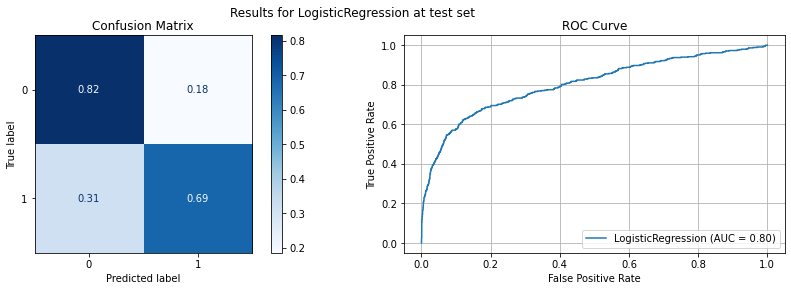

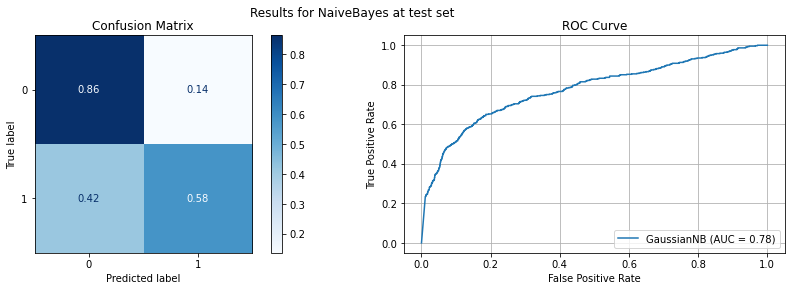

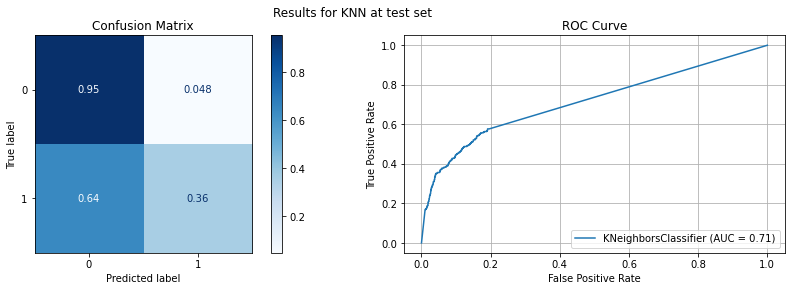

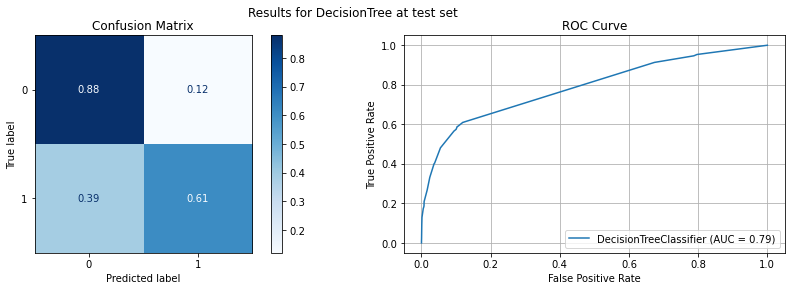

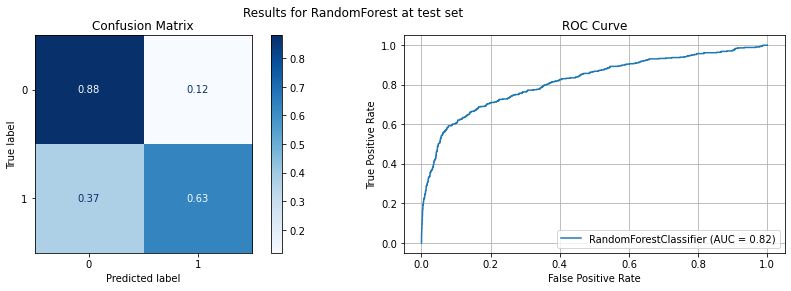

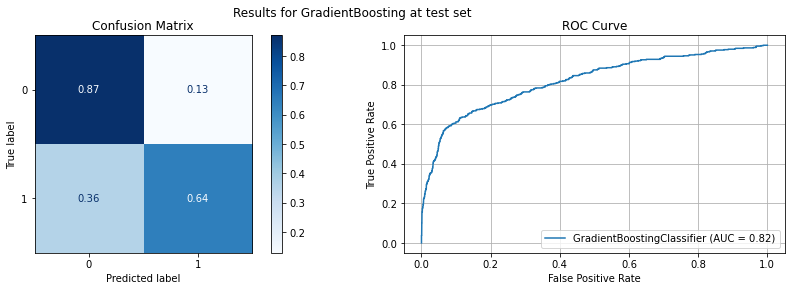

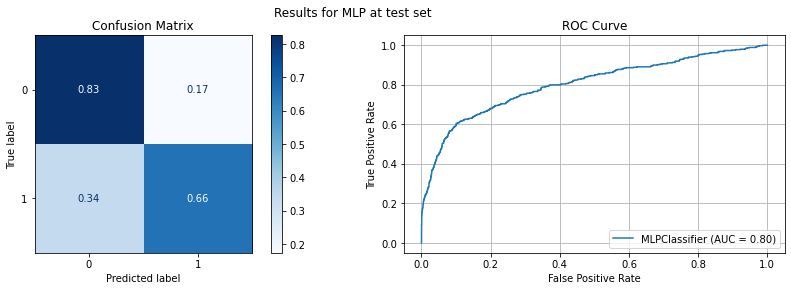

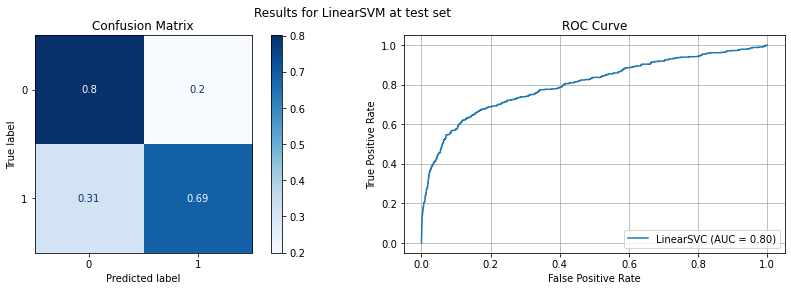

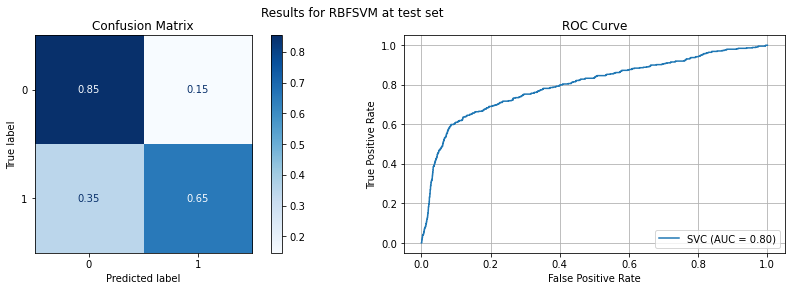

In [4]:
models_def = [
    {
        "name": "LogisticRegression", 
        "model_class": LogisticRegression,
        "transformations": [],
        "model_params": {},
        "fit_params": {"sample_weight": train_sample_weights}
    },
    {
        "name": "NaiveBayes", 
        "model_class": GaussianNB,
        "transformations": [],
        "model_params": {},
        "fit_params": {"sample_weight": train_sample_weights}
    },
    {
        "name": "KNN", 
        "model_class": KNeighborsClassifier,
        "transformations": [],
        "model_params": {"n_neighbors": 3, "weights": "distance", "n_jobs": 2},
        "fit_params": {}
    },
    {
        "name": "DecisionTree", 
        "model_class": DecisionTreeClassifier,
        "transformations": [],
        "model_params": {"max_depth": 5, "min_samples_split": 100, "min_samples_leaf": 10, "max_features": 15, "class_weight": class_weight, "random_state": 42},
        "fit_params": {}
    },
    {
        "name": "RandomForest", 
        "model_class": RandomForestClassifier,
        "transformations": [],
        "model_params": {
            "n_estimators": 100, "max_depth": 7, "min_samples_split": 25, "min_samples_leaf": 10, 
            "max_features": 10, "class_weight": class_weight, "max_samples": 0.25, "random_state": 42
        },
        "fit_params": {}
    },
    {
        "name": "GradientBoosting", 
        "model_class": GradientBoostingClassifier,
        "transformations": [],
        "model_params": {
            "n_estimators": 400, "max_depth": 5, "min_samples_split": 100, "min_samples_leaf": 10, 
            "max_features": 15, "subsample": 0.5, "n_iter_no_change": 10, "random_state": 42
        },
        "fit_params": {"sample_weight": train_sample_weights}
    },
    {
        "name": "MLP", 
        "model_class": MLPClassifier,
        "transformations": [downsample],
        "model_params": {
            "hidden_layer_sizes": (60,), "max_iter": 100, "learning_rate": "adaptive", "early_stopping": True, "random_state": 42
        },
        "fit_params": {}
    },
    {
        "name": "LinearSVM", 
        "model_class": LinearSVC,
        "transformations": [],
        "model_params": {
            "C": 1, "dual": False, "class_weight": class_weight, "random_state": 42
        },
        "fit_params": {}
    },
    {
        "name": "RBFSVM", 
        "model_class": SVC,
        "transformations": [],
        "model_params": {
            "C": 1, "kernel": "rbf", "class_weight": class_weight, "random_state": 42
        },
        "fit_params": {}
    },

]


model_results_train = pd.DataFrame(columns = ["wacc_mean", "wacc_std", "precision_mean", "precision_std", "recall_mean", "recall_std", "roc_auc_mean", "roc_auc_std"])
model_results_test = pd.DataFrame(columns = ["wacc", "precision", "recall", "roc_auc"])
if not os.path.exists(os.path.join("..", "results")): os.mkdir(os.path.join("..", "results"))

for model_def in models_def:
    model = model_def["model_class"](**model_def["model_params"])

    train_results = train_cv_model(model, transformations = model_def["transformations"], fit_params = model_def["fit_params"], model_name = model_def["name"])
    model_results_train = model_results_train.append(train_results)
    model_results_train.to_csv(os.path.join("..", "results", "train_results.csv"))

    test_results = evaluate_model(model, transformations = model_def["transformations"], fit_params = model_def["fit_params"], model_name = model_def["name"])
    model_results_test = model_results_test.append(test_results)
    model_results_test.to_csv(os.path.join("..", "results", "test_results.csv"))

model_results_test.sort_values(by = "wacc", ascending = False)



In [5]:
best_model = model_results_test.sort_values(by = "wacc", ascending = False).iloc[0].name
best_model

'GradientBoosting'

In [9]:
model_results_test.to_clipboard(decimal = ",")